# Electricity Prediction Analysis (Basic)

This notebook implements three methods to predict electricity consumption (Target) based on previous hours or historical trends:
1. **Linear Regression**: Using previous 6 hours (lag variables) as features.
2. **Holt-Winters (Triple Exponential Smoothing)**: Using the target time series.
3. **ARIMA**: Using the target time series.

Goal: Minimize Mean Absolute Percentage Error (MAPE).

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Setup Paths
data_path = Path().cwd().parent / "data" / "electricity_prediction.csv"
results_path = Path().cwd().parent / "results"
results_path.mkdir(parents=True, exist_ok=True)

print(f"Data Path: {data_path}")
print(f"Results Path: {results_path}")


Data Path: /home/bhavik/Dropbox/edu/smu/winter/data_mining/a4_regression_ts/data/electricity_prediction.csv
Results Path: /home/bhavik/Dropbox/edu/smu/winter/data_mining/a4_regression_ts/results


## 1. Data Loading & Preprocessing
Loading the data without headers and renaming columns to `Hour_1` through `Hour_6` (features) and `Target`.

In [12]:
try:
    # Load data with header=None as the file lacks headers
    df = pd.read_csv(data_path, header=None)
    
    # Rename columns
    column_names = [f'Hour_{i}' for i in range(1, 7)] + ['Target']
    df.columns = column_names
    
    print("Data Loaded Successfully.")
    print(df.info())
    display(df.head())
except FileNotFoundError:
    print("Error: Data file not found. Please check the path.")


Data Loaded Successfully.
<class 'pandas.DataFrame'>
RangeIndex: 139571 entries, 0 to 139570
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Hour_1  139571 non-null  float64
 1   Hour_2  139571 non-null  float64
 2   Hour_3  139571 non-null  float64
 3   Hour_4  139571 non-null  float64
 4   Hour_5  139571 non-null  float64
 5   Hour_6  139571 non-null  float64
 6   Target  139571 non-null  float64
dtypes: float64(7)
memory usage: 7.5 MB
None


,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Target
0,71.770335,320.574163,401.913876,344.497608,440.191388,440.191388,425.837321
1,62.200957,320.574163,344.497608,440.191388,440.191388,425.837321,397.129187
2,71.770335,358.851675,440.191388,440.191388,425.837321,397.129187,344.497608
3,66.985646,296.650718,440.191388,425.837321,397.129187,344.497608,344.497608
4,66.985646,330.143541,425.837321,397.129187,344.497608,344.497608,311.004785


## 2. Data Visualization (EDA)
Understanding the target variable and relationships.

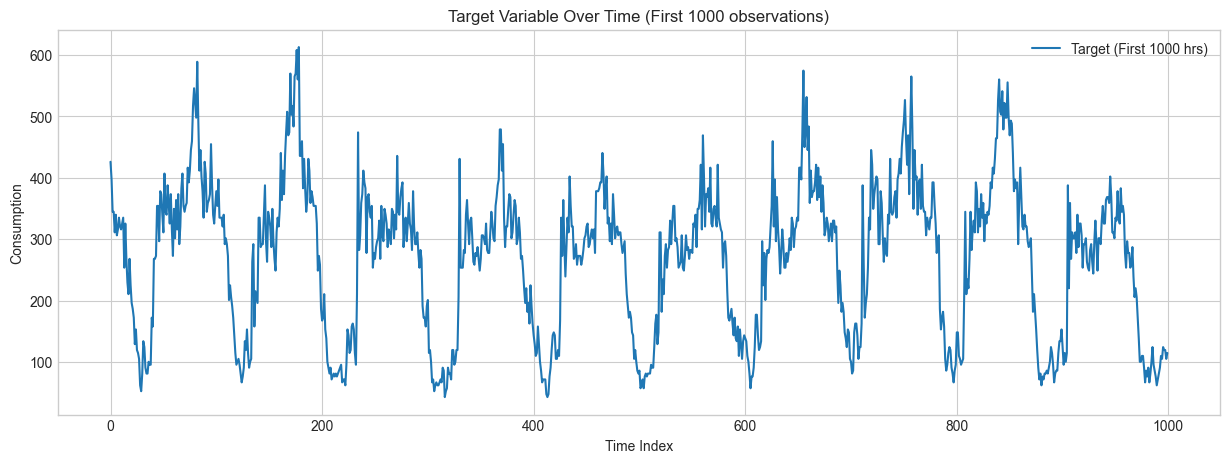

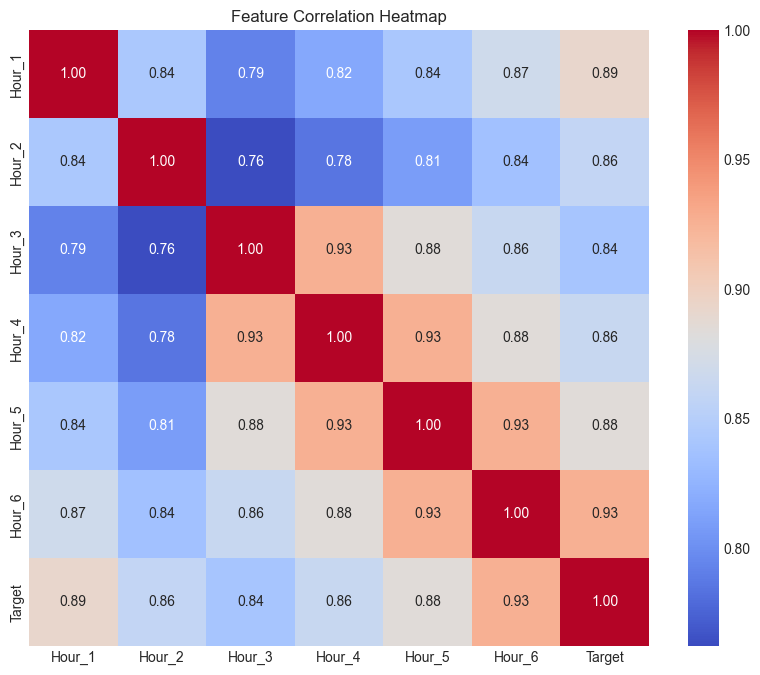

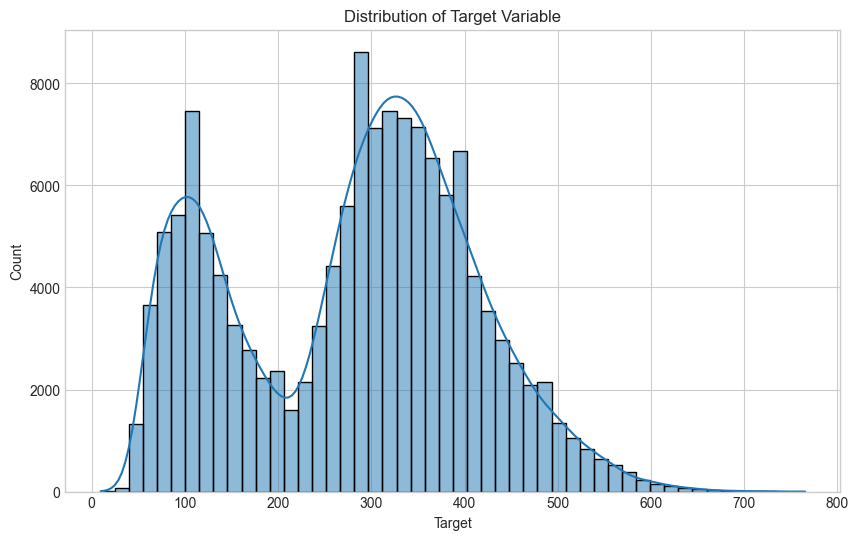

In [13]:
if 'df' in locals():
    # 1. Target Variable over Time (subset for visibility)
    plt.figure(figsize=(15, 5))
    plt.plot(df['Target'].iloc[:1000], label='Target (First 1000 hrs)')
    plt.title('Target Variable Over Time (First 1000 observations)')
    plt.xlabel('Time Index')
    plt.ylabel('Consumption')
    plt.legend()
    plt.savefig(results_path / 'target_time_series.png')
    plt.show()
    
    # 2. Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap')
    plt.savefig(results_path / 'correlation_heatmap.png')
    plt.show()
    
    # 3. Distribution of Target
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Target'], bins=50, kde=True)
    plt.title('Distribution of Target Variable')
    plt.savefig(results_path / 'target_distribution.png')
    plt.show()


In [14]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


## 3. Linear Regression
Using Hours 1-6 to predict Target.

Splitting data: 80.0% Train, 19.999999999999996% Test
Train Shape: (111656, 6), Test Shape: (27915, 6)
Linear Regression MAPE: 11.6990%


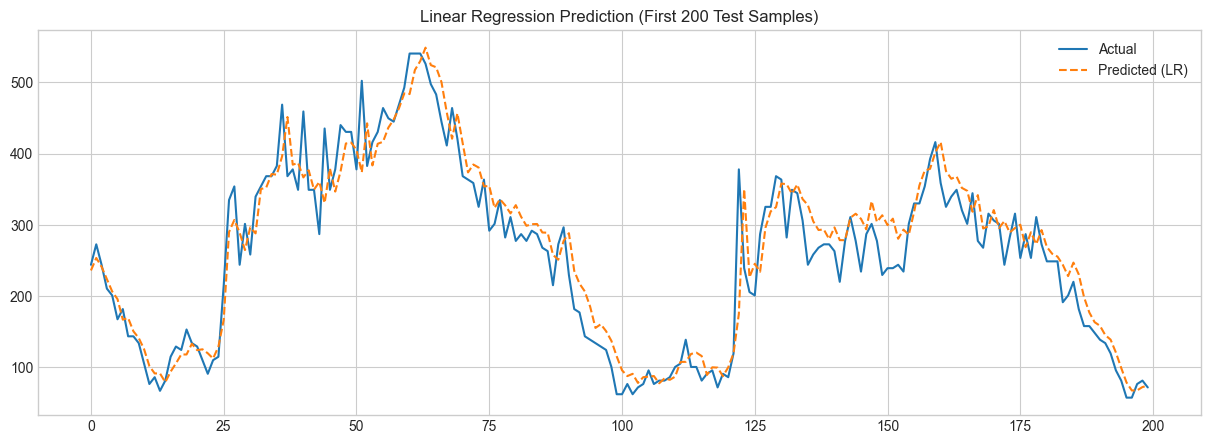

In [15]:
# Prepare Features and Target
X = df.drop('Target', axis=1)
y = df['Target']

# Standard Split using sklearn (shuffle=False to preserve time dependence)
train_size_perc = 0.8
print(f"Splitting data: {train_size_perc*100}% Train, {(1-train_size_perc)*100}% Test")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size_perc, shuffle=False)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# Train Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mape_lr = calculate_mape(y_test, y_pred_lr)
print(f"Linear Regression MAPE: {mape_lr:.4f}%")

# Plot Prediction vs Actual (Subset)
plt.figure(figsize=(15, 5))
subset_n = 200
plt.plot(y_test.values[:subset_n], label='Actual')
plt.plot(y_pred_lr[:subset_n], label='Predicted (LR)', linestyle='--')
plt.title(f'Linear Regression Prediction (First {subset_n} Test Samples)')
plt.legend()
plt.savefig(results_path / "liear_regression_prediction_first_200_test.png", dpi=300)
plt.show()


## 4. Holt-Winters (Triple Exponential Smoothing)
Using the univariate time series of `Target`.  
*Note: Holt-Winters can be computationally intensive on very large datasets. We will fit on the training portion.*

In [16]:
# Holt-Winters requires the series to have a frequency or index.
# Assuming hourly data if not specified, but we'll use integers for now or a simple seasonal period.
# Since we don't have explicit timestamps, we rely on the seasonal_periods parameter.
# Assuming daily seasonality (24 hours).

seasonal_period = 24

print("Training Holt-Winters Model... this might take a moment.")
try:
    # Standard HW with additive trend and seasonality
    hw_model = ExponentialSmoothing(
        y_train, 
        seasonal_periods=seasonal_period, 
        trend='add', 
        seasonal='add',
        initialization_method="estimated"
    ).fit()

    # Forecast
    y_pred_hw = hw_model.forecast(len(y_test))

    # Evaluate
    mape_hw = calculate_mape(y_test, y_pred_hw)
    print(f"Holt-Winters MAPE: {mape_hw:.4f}%")
except Exception as e:
    print(f"Holt-Winters failed: {e}")
    mape_hw = np.nan


Training Holt-Winters Model... this might take a moment.
Holt-Winters MAPE: 56.3848%


## 5. ARIMA
Auto-Regressive Integrated Moving Average.

In [17]:
# Stationarity Check (ADF Test)
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is Stationary")
    else:
        print("Data is Non-Stationary")

print("Checking Stationarity on a subset (first 5000 samples) for speed...")
check_stationarity(y_train.iloc[:5000])


Checking Stationarity on a subset (first 5000 samples) for speed...
ADF Statistic: -16.261121740790795
p-value: 3.5649196044185184e-29
Data is Stationary


In [18]:
# Train ARIMA
# Note: ARIMA on 100k+ points is very slow. We might fit on a smaller recent history 
# or strictly enforce a simple order. 
# For demonstration, we will use a simple order (1, 1, 1) or (5,1,0) generic.
# A proper Auto-ARIMA (pmdarima) is recommended but standard statsmodels is used here.

print("Training ARIMA Model... (Fitting on recent 5000 samples to save time for this demo)")
try:
    # Fitting on the LAST 5000 points of training data to capture recent dynamics
    # Using (p,d,q) = (5,1,0) as a starting point (AR=5)
    arima_model = ARIMA(y_train.iloc[-5000:], order=(5, 1, 0))
    arima_model_fit = arima_model.fit()

    # Forecast
    # Note: forecasting huge horizon with ARIMA can be flat. 
    # We will forecast the beginning of test set for comparison.
    forecast_steps = 200 # Forecasting first 200 steps of test set for visualization/validity
    y_pred_arima = arima_model_fit.forecast(steps=forecast_steps)
    
    # Calculate MAPE for this subset
    mape_arima = calculate_mape(y_test.iloc[:forecast_steps], y_pred_arima)
    print(f"ARIMA MAPE (First {forecast_steps} steps): {mape_arima:.4f}%")
    
except Exception as e:
    print(f"ARIMA failed: {e}")
    mape_arima = np.nan


Training ARIMA Model... (Fitting on recent 5000 samples to save time for this demo)
ARIMA MAPE (First 200 steps): 60.6968%


## 6. Model Comparison

,Model,MAPE (%)
0,Linear Regression,11.699001
1,Holt-Winters,56.384802
2,ARIMA (subset),60.696847


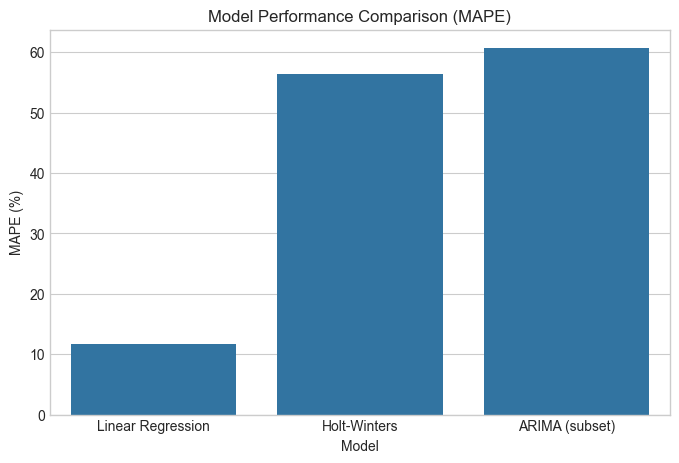

In [19]:
results = {
    'Model': ['Linear Regression', 'Holt-Winters', 'ARIMA (subset)'],
    'MAPE (%)': [mape_lr, mape_hw, mape_arima]
}

results_df = pd.DataFrame(results)
display(results_df)

# Bar plot of MAPEs
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MAPE (%)', data=results_df)
plt.title('Model Performance Comparison (MAPE)')
plt.savefig(results_path / 'model_comparison.png')
plt.show()
